In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shlex
from scipy.stats import ttest_rel,ttest_ind,wilcoxon,ranksums,pearsonr,spearmanr
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import explained_variance_score,mean_squared_error
from statsmodels.stats.multitest import multipletests
import subprocess
import scipy
import sys
sys.path.append("../code")
from analysis_utils import *

In [2]:
sns.set_context('notebook',font_scale=1.5)

In [3]:
df = pd.read_table('../data/Pioneer_TF_library.csv')

In [4]:
expts = ['rarrxr1_slotv4_endoderm_rep1a',
         'rarrxr1_slotv4_endoderm_rep1b',
         'rarrxr1_slotv4_endoderm_rep2a',
         'rarrxr1_slotv4_endoderm_rep2b',
         'rarrxr1_slotv4_mesc_repa',
         'rarrxr1_slotv4_mesc_repb']
for expt in expts:
    df[expt+'_dpnii_norm'] = df[expt+'_dpnii']/(np.sum(df[expt+'_dpnii'])/1000000)
    df[expt+'_dpni_norm'] = df[expt+'_dpni']/(np.sum(df[expt+'_dpni'])/1000000)
    df[expt+' Dpn Ratio'] = df[expt+'_dpnii_norm']/(df[expt+'_dpnii_norm']+df[expt+'_dpni_norm'])
df['ES Dpn ratio'] = (df['rarrxr1_slotv4_mesc_repa Dpn Ratio'] +df['rarrxr1_slotv4_mesc_repb Dpn Ratio'])/ 2.0
df['ED Dpn ratio'] = (df['rarrxr1_slotv4_endoderm_rep1a Dpn Ratio'] + df['rarrxr1_slotv4_endoderm_rep1b Dpn Ratio'] + df['rarrxr1_slotv4_endoderm_rep2a Dpn Ratio'] + df['rarrxr1_slotv4_endoderm_rep2b Dpn Ratio'])/ 4.0

In [5]:
df['total normalized reads'] = df[[c for c in df.columns if 'dpni_norm' in c or 'dpnii_norm' in c]].sum(axis=1)
df['ES Dpn std'] = df[[c for c in df.columns if 'Dpn Ratio' in c and 'mesc' in c]].std(axis=1)
df['ED Dpn std'] = df[[c for c in df.columns if 'Dpn Ratio' in c and 'endoderm' in c]].std(axis=1)

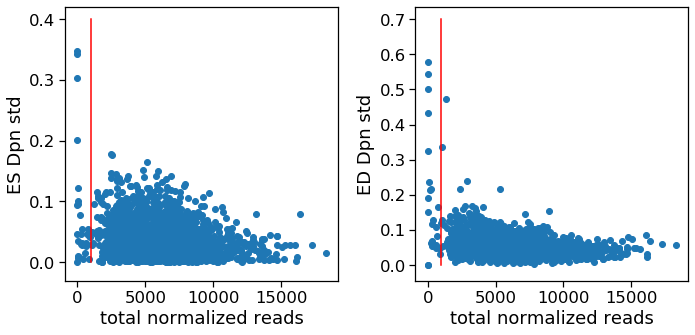

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(x='total normalized reads',y='ES Dpn std',data=df)
plt.plot([1000,1000],[0.0,0.4],color='r')
plt.xlabel('total normalized reads')
plt.ylabel('ES Dpn std')
plt.tight_layout()
plt.subplot(1,2,2)
plt.scatter(x='total normalized reads',y='ED Dpn std',data=df)
plt.plot([1000,1000],[0.0,0.7],color='r')
plt.xlabel('total normalized reads')
plt.ylabel('ED Dpn std')
plt.tight_layout()
plt.savefig('plots/threshold_2k_library.svg')

In [7]:
df = df[df['total normalized reads'] > 1000]
df['distance'] = df['distance'].astype(str)

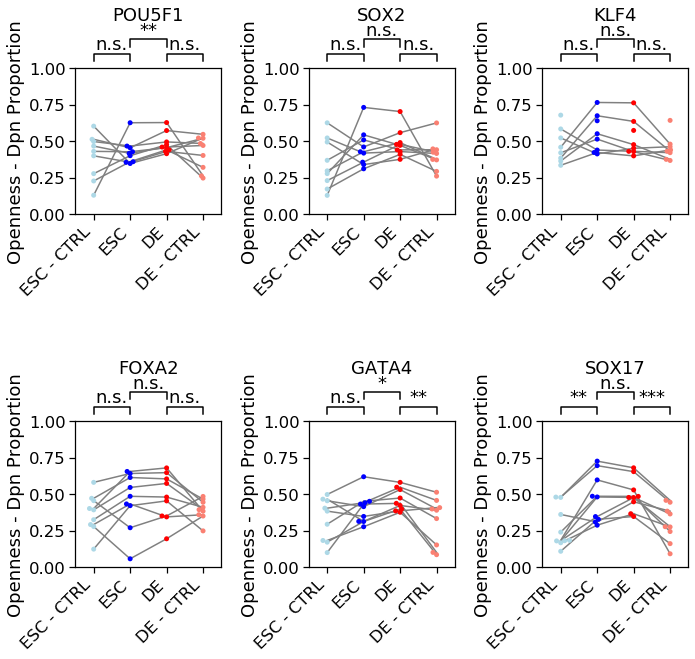

In [8]:
def rename(name):
    newname = ''
    if 'ES' in name:
        newname += 'ESC'
    else:
        newname += 'DE'
    if 'scrambled' in name:
        newname += ' - CTRL'
    return newname
pltind=1
plt.figure(figsize=(10,11))
tfs = ['oct4','sox2','klf4','foxa2','gata4','sox17']
tf2name = {'oct4':'POU5F1',
           'sox2':'SOX2',
           'klf4':'KLF4',
           'foxa2':'FOXA2',
           'gata4':'GATA4',
           'sox17':'SOX17'}
for tf in tfs:
    plt.subplot(3,3,pltind)
    tfkeep = df[df['tf']==tf]
    keep_pd = tfkeep.pivot_table(index=['background','distance'],columns=['control'],
                                 values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    plot_dotplot(tfkeep,['seq','background','tf','distance','control'],keep_pd,title=tf2name[tf])
    pltind+=1
plt.savefig('plots/known_motifs_single_instance.svg',bbox_inches='tight')

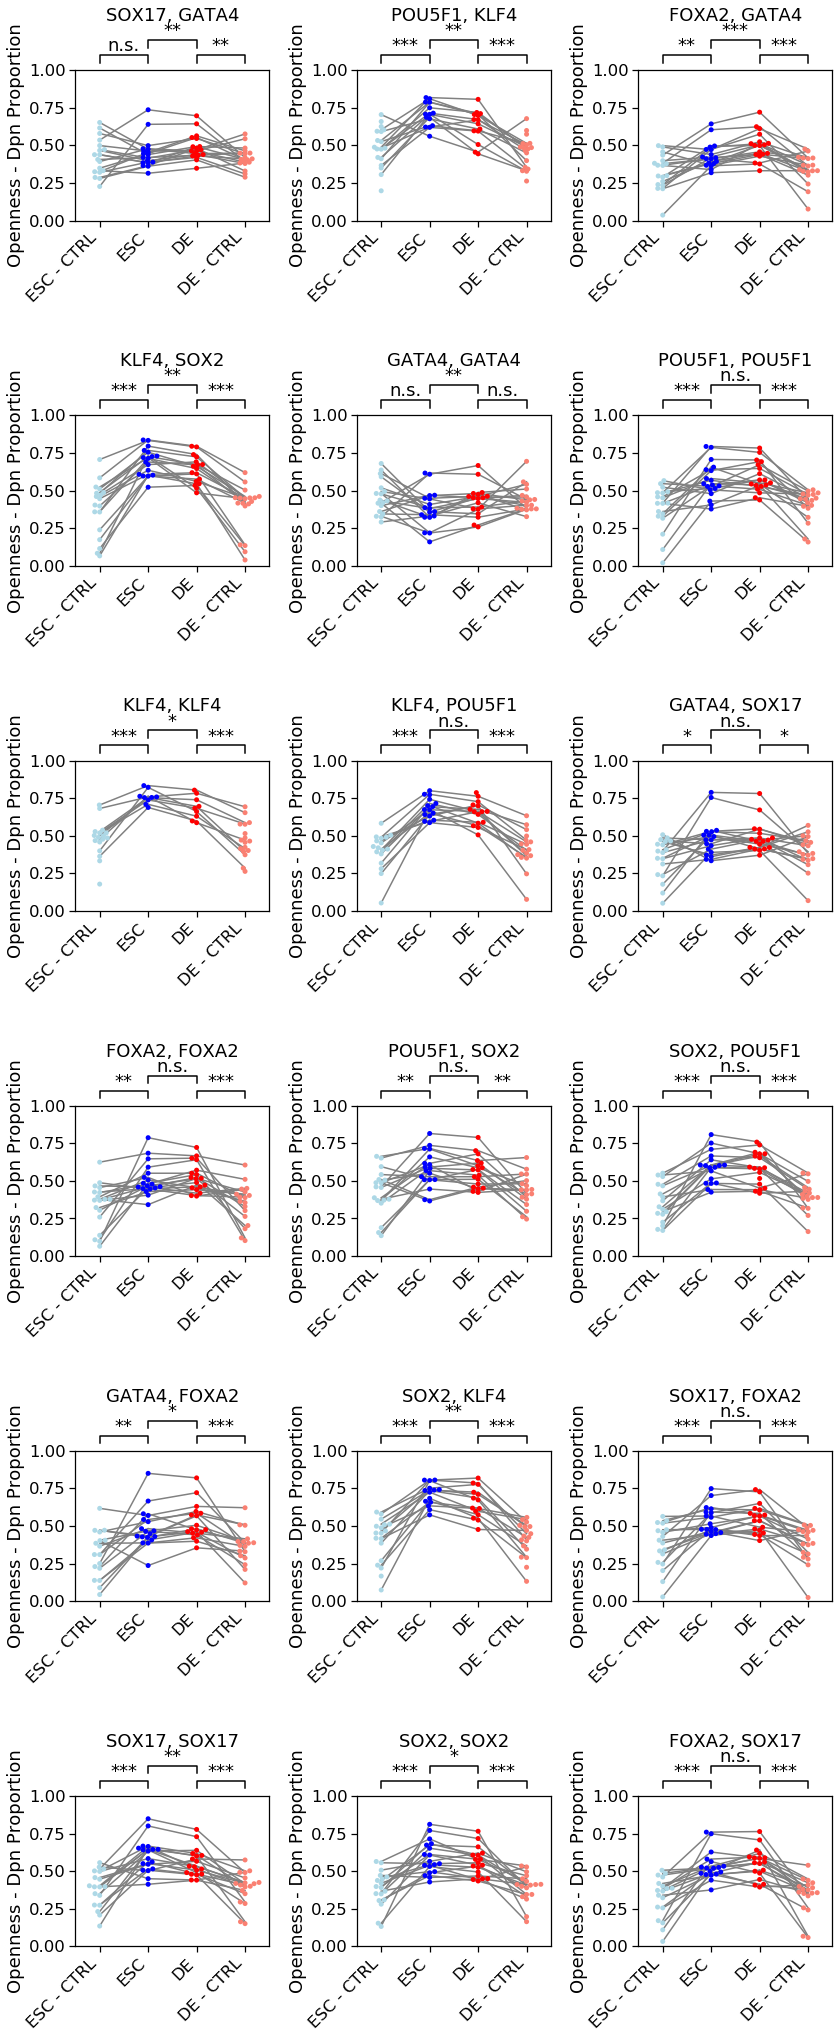

In [9]:
pltind=1
plt.figure(figsize=(12,25))
tfs = ['oct4','sox2','klf4','foxa2','gata4','sox17']
dimers = set([c for c in set(df['tf']) for tf in tfs
        if ((tf in c)) and len(c.split(',')) == 2])
for tf in dimers:
    tfnames = ', '.join([tf2name[t] for t in tf.split(',')])
    plt.subplot(6,3,pltind)
    tfkeep = df[df['tf']==tf]
    keep_pd = tfkeep.pivot_table(index=['background','distance'],columns=['control'],
                                 values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    plot_dotplot(tfkeep,['seq','background','tf','distance','control'],keep_pd,title=tfnames)
    pltind+=1
    
plt.savefig('plots/known_motifs_double_instance.svg',bbox_inches='tight')

# Differential compared to scrambled

In [10]:
wilcoxon_tests = {}
ttest_tests = {}
keep = df[df['tf'].isin([c for c in set(df['tf']) for tf in tfs
                                      if ((tf in c))])]
all_cats = list(set(keep['tf']))

for cat in all_cats:
    for distance in set(keep['distance']):
        keep_cat = keep[(keep['tf']==cat)&(keep['control']=='motif')&(keep['distance']==distance)]
        keep_pd = keep_cat.pivot_table(index=['background','distance'],values=['ES Dpn ratio','ED Dpn ratio']).dropna()
        if len(keep_cat) > 0:
            wilcoxon_tests[cat+'-'+distance] = wilcoxon(keep_pd['ES Dpn ratio'],keep_pd['ED Dpn ratio'])
            ttest_tests[cat+'-'+distance] = ttest_rel(keep_pd['ES Dpn ratio'],keep_pd['ED Dpn ratio'])
    
tests = wilcoxon_tests.keys()
wilcoxon_pvals = np.array([wilcoxon_tests[cat][1] for cat in tests])
ttest_pvals = np.array([ttest_tests[cat][1] for cat in tests])
wilcoxon_true,_,_,_ = multipletests(wilcoxon_pvals,method='fdr_bh')
ttest_true,_,_,_ = multipletests(ttest_pvals,method='fdr_bh')
diff_sig_cats = [cat for i,cat in enumerate(tests) if ttest_true[i] and wilcoxon_true[i]]

/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [11]:
wilcoxon_tests = {}
ttest_tests = {}
all_cats = list(set(keep['tf']))
for cat in all_cats:
    keep_motif = keep[(keep['tf']==cat)&(keep['control']=='motif')]
    def contains_motifs(df_cat):
        data = cat.split(',')
        for tf in data:
            if tf not in df_cat:
                return False
        return True
    keep_ctrl = keep[keep['tf']==cat]
    keep_ctrl = keep_ctrl[keep_ctrl['control']=='scrambled']
    keep_cat = pd.concat([keep_ctrl,keep_motif])
    keep_pd = keep_cat.pivot_table(index=['background','distance'],columns=['control'],
                                   values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    es_scram = wilcoxon(keep_pd['ES Dpn ratio'].motif,keep_pd['ES Dpn ratio'].scrambled)
    ed_scram = wilcoxon(keep_pd['ED Dpn ratio'].motif,keep_pd['ED Dpn ratio'].scrambled)
    wilcoxon_tests[cat] = min(es_scram[1],ed_scram[1])
    es_scram = ttest_rel(keep_pd['ES Dpn ratio'].motif,keep_pd['ES Dpn ratio'].scrambled)
    ed_scram = ttest_rel(keep_pd['ED Dpn ratio'].motif,keep_pd['ED Dpn ratio'].scrambled)
    ttest_tests[cat] = min(es_scram[1],ed_scram[1])
wilcoxon_pvals = np.array([wilcoxon_tests[cat] for cat in all_cats])
ttest_pvals = np.array([ttest_tests[cat] for cat in all_cats])
wilcoxon_true,_,_,_ = multipletests(wilcoxon_pvals,method='fdr_bh')
ttest_true,_,_,_ = multipletests(ttest_pvals,method='fdr_bh')
scram_sig_cats = [cat for i,cat in enumerate(all_cats) if ttest_true[i] and wilcoxon_true[i]]

In [12]:
len(scram_sig_cats)
print(len([c for c in scram_sig_cats if len(c.split(','))==1]),'/',len([c for c in all_cats if len(c.split(','))==1]),'singles')
print(len([c for c in scram_sig_cats if len(c.split(','))==2]),'/',len([c for c in all_cats if len(c.split(','))==2]),'pairs')
print(len([c for c in scram_sig_cats if len(c.split(','))==3]),'/',len([c for c in all_cats if len(c.split(','))==3]),'triplets')
print(len([c for c in scram_sig_cats]),'/',len([c for c in all_cats]),'total')

2 / 6 singles
17 / 18 pairs
16 / 18 triplets
35 / 42 total


# Differential between cell types

In [13]:
wilcoxon_tests = {}
ttest_tests = {}
all_cats = list(set(keep['tf']))
for cat in all_cats:
    keep_cat = keep[(keep['tf']==cat)&(keep['control']=='motif')]
    keep_pd = keep_cat.pivot_table(index=['background','distance'],values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    wilcoxon_tests[cat] = wilcoxon(keep_pd['ES Dpn ratio'],keep_pd['ED Dpn ratio'])
    ttest_tests[cat] = ttest_rel(keep_pd['ES Dpn ratio'],keep_pd['ED Dpn ratio'])
    
wilcoxon_pvals = np.array([wilcoxon_tests[cat][1] for cat in all_cats])
ttest_pvals = np.array([ttest_tests[cat][1] for cat in all_cats])
wilcoxon_true,_,_,_ = multipletests(wilcoxon_pvals,method='fdr_bh')
ttest_true,_,_,_ = multipletests(ttest_pvals,method='fdr_bh')
diff_sig_cats = [cat for i,cat in enumerate(all_cats) if ttest_true[i] and wilcoxon_true[i]]

In [14]:
len(scram_sig_cats)
print(len([c for c in diff_sig_cats if len(c.split(','))==1]),'/',len([c for c in all_cats if len(c.split(','))==1]),'singles')
print(len([c for c in diff_sig_cats if len(c.split(','))==2]),'/',len([c for c in all_cats if len(c.split(','))==2]),'pairs')
print(len([c for c in diff_sig_cats if len(c.split(','))==3]),'/',len([c for c in all_cats if len(c.split(','))==3]),'triplets')
print(len([c for c in diff_sig_cats]),'/',len([c for c in all_cats]),'total')

1 / 6 singles
10 / 18 pairs
6 / 18 triplets
17 / 42 total


# Differential to scrambled and between cell types

In [15]:
scram_wilcoxon_tests = {}
scram_ttest_tests = {}
for cat in diff_sig_cats:
    keep_motif = keep[(keep['tf']==cat)&(keep['control']=='motif')]
    def contains_motifs(df_cat):
        data = cat.split(',')
        for tf in data:
            if tf not in df_cat:
                return False
        return True
    keep_ctrl = keep[keep['tf']==cat]
    keep_ctrl = keep_ctrl[keep_ctrl['control']=='scrambled']
    keep_cat = pd.concat([keep_ctrl,keep_motif])
    keep_pd = keep_cat.pivot_table(index=['background','distance'],columns=['control'],
                                   values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    es_scram = wilcoxon(keep_pd['ES Dpn ratio'].motif,keep_pd['ES Dpn ratio'].scrambled)
    ed_scram = wilcoxon(keep_pd['ED Dpn ratio'].motif,keep_pd['ED Dpn ratio'].scrambled)
    if es_scram[1] < ed_scram[1]:
        scram_wilcoxon_tests[cat] = es_scram
    else:
        scram_wilcoxon_tests[cat] = ed_scram
    es_scram = ttest_rel(keep_pd['ES Dpn ratio'].motif,keep_pd['ES Dpn ratio'].scrambled)
    ed_scram = ttest_rel(keep_pd['ED Dpn ratio'].motif,keep_pd['ED Dpn ratio'].scrambled)
    if es_scram[1] < ed_scram[1]:
        scram_ttest_tests[cat] = es_scram
    else:
        scram_ttest_tests[cat] = ed_scram
wilcoxon_pvals = np.array([scram_wilcoxon_tests[cat][1] for cat in diff_sig_cats])
ttest_pvals = np.array([scram_ttest_tests[cat][1] for cat in diff_sig_cats])

wilcoxon_true,_,_,_ = multipletests(wilcoxon_pvals,method='fdr_bh')
ttest_true,_,_,_ = multipletests(ttest_pvals,method='fdr_bh')
scram_diff_sig_cats = [cat for i,cat in enumerate(diff_sig_cats) if ttest_true[i] and wilcoxon_true[i]]
scram_diff_sig_ordered = sorted(scram_diff_sig_cats,key=lambda x:ttest_tests[x][1])

In [16]:
len(scram_sig_cats)
print(len([c for c in scram_diff_sig_cats if len(c.split(','))==1]),'/',len([c for c in all_cats if len(c.split(','))==1]),'singles')
print(len([c for c in scram_diff_sig_cats if len(c.split(','))==2]),'/',len([c for c in all_cats if len(c.split(','))==2]),'pairs')
print(len([c for c in scram_diff_sig_cats if len(c.split(','))==3]),'/',len([c for c in all_cats if len(c.split(','))==3]),'triplets')
print(len([c for c in scram_diff_sig_cats]),'/',len([c for c in all_cats]),'total')

0 / 6 singles
9 / 18 pairs
6 / 18 triplets
15 / 42 total


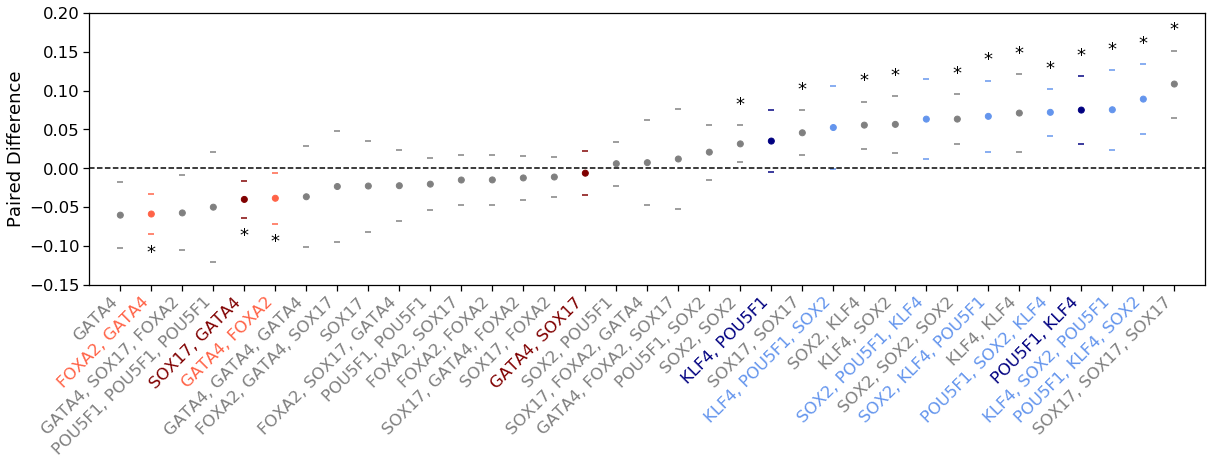

In [17]:
def rename(name):
    newname = ''
    if 'ES' in name:
        newname += 'ESC'
    else:
        newname += 'DE'
    if 'scrambled' in name:
        newname += ' - CTRL'
    return newname

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m-h, m+h

def sort_order(cat):
    tfkeep = df[df['tf']==cat]
    keep_pd = tfkeep.pivot_table(index=['background','distance'],columns=['control'],
                                 values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    l,h = mean_confidence_interval(keep_pd['ES Dpn ratio']['motif']-keep_pd['ED Dpn ratio']['motif'])
    m = np.mean(keep_pd['ES Dpn ratio']['motif']-keep_pd['ED Dpn ratio']['motif'])
    return m
    #if m < 0:
    #    return h
    #else: 
    #    return l

scram_sig_ordered = sorted(scram_sig_cats,key=lambda x:sort_order(x))

pltind=1
es_size = []
es_low = []
es_high = []
ed_size = []
ed_low = []
ed_high = []
colors = []
cat_starred=[]
for cat in scram_sig_ordered:
    tfkeep = df[df['tf']==cat]
    tfnames = ', '.join([tf2name[t] for t in cat.split(',')])

    keep_pd = tfkeep.pivot_table(index=['background','distance'],columns=['control'],
                                 values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    es_size.append(np.mean(keep_pd['ES Dpn ratio']['motif']-keep_pd['ED Dpn ratio']['motif']))
    l,h = mean_confidence_interval(keep_pd['ES Dpn ratio']['motif']-keep_pd['ED Dpn ratio']['motif'])
    es_low.append(l)
    es_high.append(h)
    if cat in scram_diff_sig_ordered:
        cat_starred.append(True)
    else:
        cat_starred.append(False)
    if 'gata4' in cat and 'sox17' in cat and len(cat.split(',')) == 2:
        colors.append('maroon')
    elif 'gata4' in cat and 'foxa2' in cat and len(cat.split(',')) == 2:
        colors.append('tomato')
    elif 'oct4' in cat and 'klf4' in cat and len(cat.split(',')) == 2:
        colors.append('navy')
    elif 'oct4' in cat and 'klf4' in cat and 'sox2' in cat:
        colors.append('cornflowerblue')
    else:
        colors.append('grey')
    
fig = plt.figure(figsize=(20,5))
ax = plt.subplot(1,1,1)
plt.scatter(np.arange(len(scram_sig_ordered)),es_size,color=colors)
plt.scatter(np.arange(len(scram_sig_ordered)),es_low,color=colors,marker='_')
plt.scatter(np.arange(len(scram_sig_ordered)),es_high,color=colors,marker='_')
plt.plot([-1,len(scram_sig_ordered)],[0,0],'--k')

for i,star in enumerate(cat_starred):
    if star:
        if es_size[i] < 0:
            plt.text(np.arange(len(scram_sig_ordered))[i],
                    es_low[i]-0.03,'*',ha='center')
        else:
            plt.text(np.arange(len(scram_sig_ordered))[i],
                    es_high[i]+0.02,'*',ha='center')
def tf_name(tf):
    if tf.upper() == 'OCT4':
        return 'POU5F1'
    else:
        return tf.upper() 
    
tf_names = [', '.join([tf_name(s) for s in slist.split(',')]) for slist in scram_sig_ordered]
plt.xticks(np.arange(len(scram_sig_ordered)),
           tf_names,
           color=colors,
           rotation=45,
           ha='right')
[l.set_color(c) for (c,l) in
 zip(colors,ax.xaxis.get_ticklabels())]

plt.axis([-1,len(scram_sig_ordered),-0.15,0.20])
plt.ylabel('Paired Difference')
plt.savefig('plots/pioneer_library_significant_by_difference_95ci.svg')

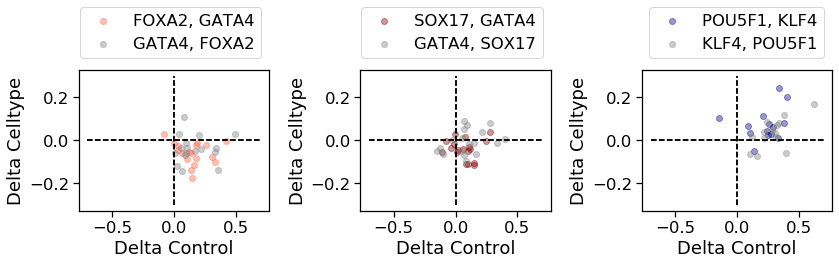

In [20]:
plt.figure(figsize=(12,4))
pltind=1
colors = ['tomato','maroon','navy']
ct = ['ED','ED','ES']
for cat_pair in [['foxa2,gata4','gata4,foxa2'],['sox17,gata4','gata4,sox17'],['oct4,klf4','klf4,oct4']]:
    plt.subplot(1,3,pltind)
    for i,cat in enumerate(cat_pair):
        tfnames = ', '.join([tf2name[t] for t in cat.split(',')])

        tfkeep = keep[keep['tf']==cat]        
        keep_pd = tfkeep.pivot_table(index=['background','distance'],columns=['control'],
                                       values=['ES Dpn ratio','ED Dpn ratio']).dropna()
        if i == 0:
            plt.scatter(y=keep_pd['ES Dpn ratio']['motif']-keep_pd['ED Dpn ratio']['motif'],
                       x=keep_pd[ct[pltind-1]+' Dpn ratio']['motif']-keep_pd[ct[pltind-1]+' Dpn ratio']['scrambled'],color=colors[pltind-1],alpha=0.4,label=tfnames)
        else:
            plt.scatter(y=keep_pd['ES Dpn ratio']['motif']-keep_pd['ED Dpn ratio']['motif'],
                       x=keep_pd[ct[pltind-1]+' Dpn ratio']['motif']-keep_pd[ct[pltind-1]+' Dpn ratio']['scrambled'],color='grey',alpha=0.4,label=tfnames)#facecolors='none',edgecolors=colors[pltind-1])
        plt.plot([-0.7,0.7],[0,0],'--k') 
        plt.plot([0,0],[-0.3,0.3],'--k') 
        plt.legend(bbox_to_anchor=(1.0,1.5))
        plt.ylabel('Delta Celltype')
        plt.xlabel('Delta Control')
        plt.tight_layout()
    pltind+=1
plt.savefig('plots/differentially_significant_orderings_scatter.svg',bbox_inches='tight')

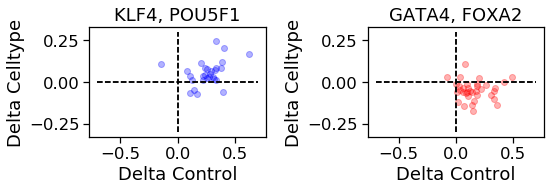

In [25]:
plt.figure(figsize=(8,3))
pltind=1
colors = ['blue','red']
ct = ['ES','ED']
for cat_pair in [['oct4,klf4','klf4,oct4'],['foxa2,gata4','gata4,foxa2']]:
    plt.subplot(1,2,pltind)
    for i,cat in enumerate(cat_pair):
        tfnames = ', '.join([tf2name[t] for t in cat.split(',')])

        tfkeep = keep[keep['tf']==cat]        
        keep_pd = tfkeep.pivot_table(index=['background','distance'],columns=['control'],
                                       values=['ES Dpn ratio','ED Dpn ratio']).dropna()
        if i == 0:
            plt.scatter(y=keep_pd['ES Dpn ratio']['motif']-keep_pd['ED Dpn ratio']['motif'],
                    x=keep_pd[ct[pltind-1]+' Dpn ratio']['motif']-keep_pd[ct[pltind-1]+' Dpn ratio']['scrambled'],color=colors[pltind-1],alpha=0.3,label=tfnames)
        else:
            plt.scatter(y=keep_pd['ES Dpn ratio']['motif']-keep_pd['ED Dpn ratio']['motif'],
                    x=keep_pd[ct[pltind-1]+' Dpn ratio']['motif']-keep_pd[ct[pltind-1]+' Dpn ratio']['scrambled'],color=colors[pltind-1],alpha=0.3)
        plt.plot([-0.7,0.7],[0,0],'--k') 
        plt.plot([0,0],[-0.3,0.3],'--k') 
        #plt.legend(bbox_to_anchor=(1.0,1.3))
        plt.title(tfnames)
        plt.ylabel('Delta Celltype')
        plt.xlabel('Delta Control')
        plt.tight_layout()
    pltind+=1
plt.savefig('plots/show_twotfs_differential_scatter.svg',bbox_inches='tight')

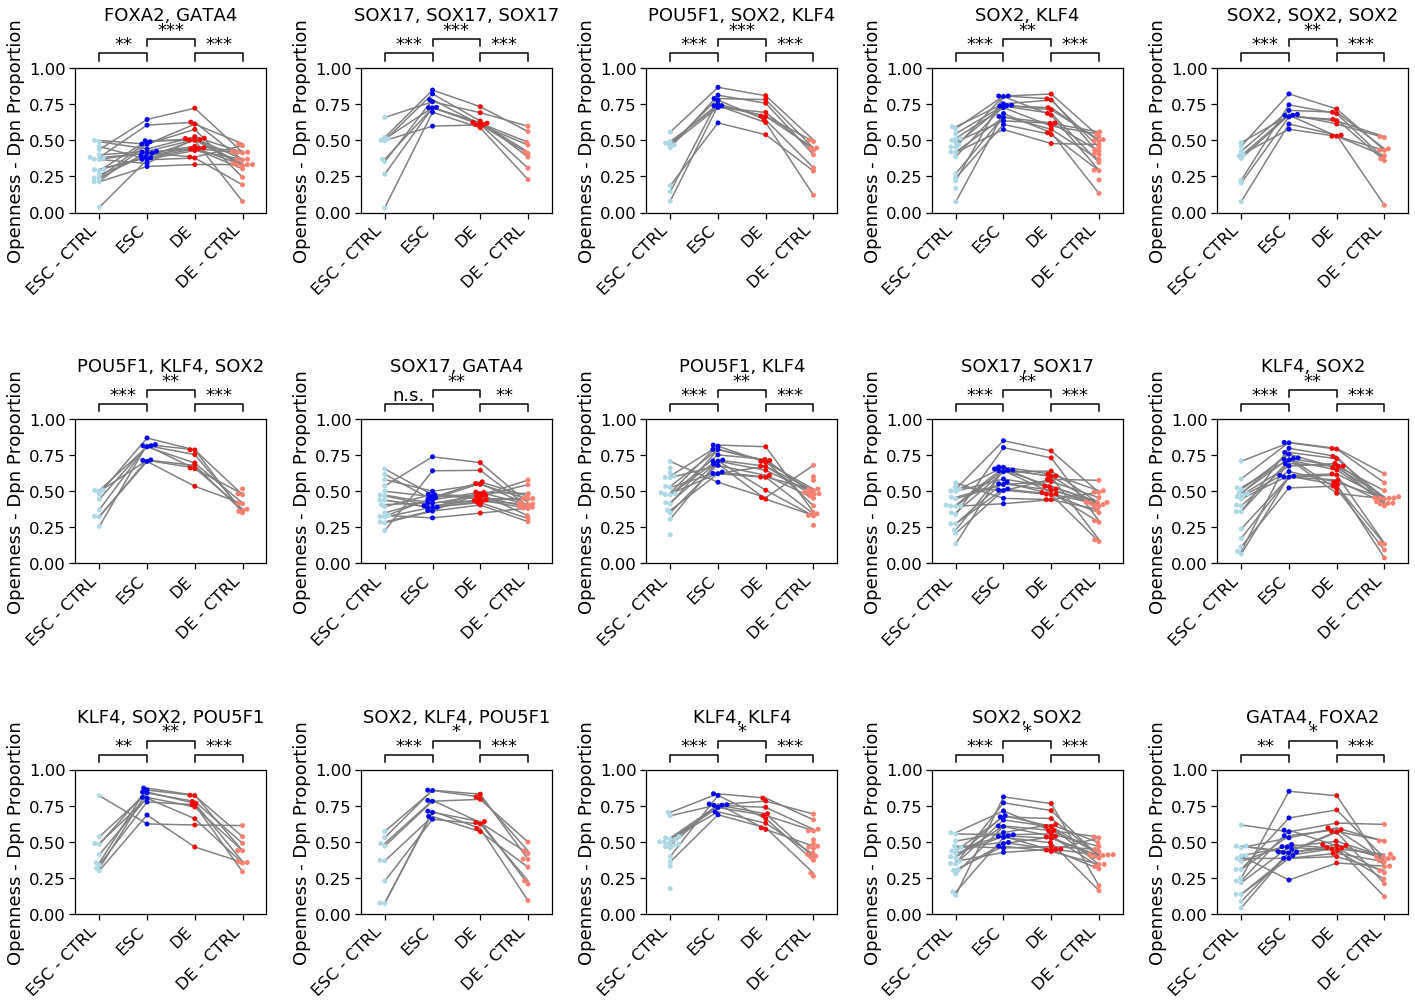

In [18]:
plt.figure(figsize=(20,12))
pltind=1
for cat in scram_diff_sig_ordered:
    plt.subplot(3,5,pltind)
    tfnames = ', '.join([tf2name[t] for t in cat.split(',')])

    tfkeep = keep[keep['tf']==cat]        
    keep_pd = tfkeep.pivot_table(index=['background','distance'],columns=['control'],
                                   values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    plot_dotplot(tfkeep,['seq','background','tf','distance','control'],keep_pd,title=tfnames)    
    pltind+=1
    
plt.savefig('plots/differentially_significant_combinations.svg',bbox_inches='tight')

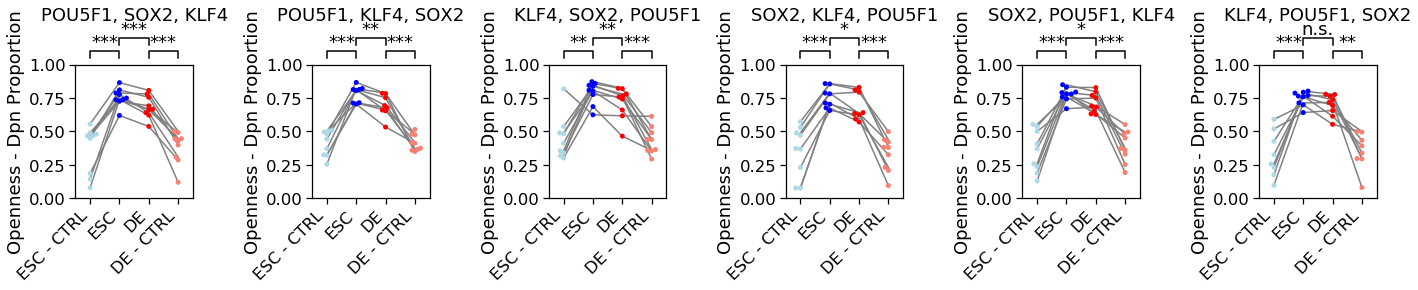

In [19]:
plt.figure(figsize=(20,3))
pltind=1
for cat in ['oct4,sox2,klf4','oct4,klf4,sox2','klf4,sox2,oct4','sox2,klf4,oct4','sox2,oct4,klf4','klf4,oct4,sox2']:
    tfnames = ', '.join([tf2name[t] for t in cat.split(',')])
    plt.subplot(1,6,pltind)
    tfkeep = keep[keep['tf']==cat]
    keep_pd = tfkeep.pivot_table(index=['background','distance'],
                                   columns=['control'],values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    plot_dotplot(tfkeep,['seq','background','tf','distance','control'],keep_pd,title=tfnames)    
    pltind+=1    
plt.savefig('plots/OSK_combinations.svg',bbox_inches='tight')

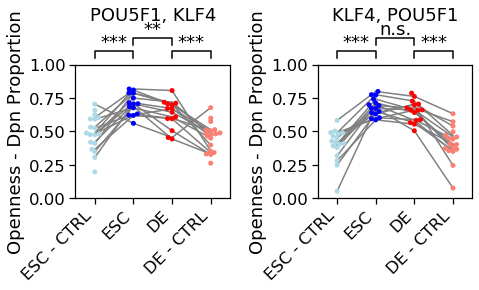

In [20]:
plt.figure(figsize=(7,3))
pltind=1

for cat in ['oct4,klf4','klf4,oct4']:
    plt.subplot(1,2,pltind)
    tfnames = ', '.join([tf2name[t] for t in cat.split(',')])

    tfkeep = keep[keep['tf']==cat]
    keep_pd = tfkeep.pivot_table(index=['background','distance'],
                                   columns=['control'],values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    plot_dotplot(tfkeep,['seq','background','tf','distance','control'],keep_pd,title=tfnames)
    pltind += 1
plt.savefig('plots/oct_klf4_combinations.svg',bbox_inches='tight')

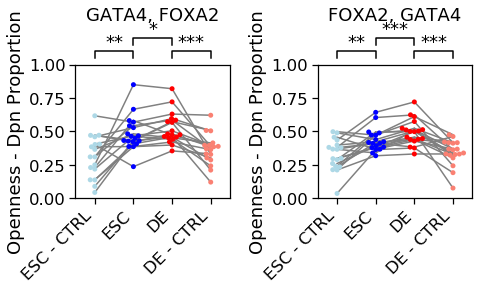

In [21]:
plt.figure(figsize=(7,3))
pltind=1

cat2name={'foxa2,gata4':'Oct4,Klf4','klf4,oct4':'Klf4,Oct4'}
for cat in [c for c in all_cats if 'foxa2' in c and 'gata4' in c and 'sox17' not in c]:
    plt.subplot(1,2,pltind)
    tfnames = ', '.join([tf2name[t] for t in cat.split(',')])

    tfkeep = keep[keep['tf']==cat]

    keep_pd = tfkeep.pivot_table(index=['background','distance'],
                                   columns=['control'],values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    plot_dotplot(tfkeep,['seq','background','tf','distance','control'],keep_pd,title=tfnames)
    pltind += 1
plt.savefig('plots/fox_gata_combinations.svg',bbox_inches='tight')

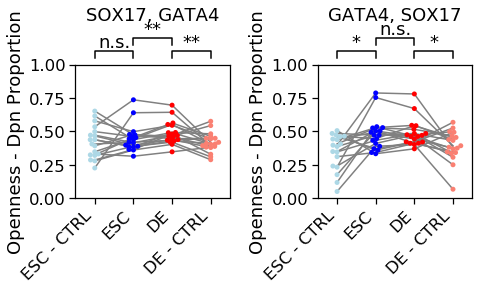

In [22]:
plt.figure(figsize=(7,3))
pltind=1
for cat in ['sox17,gata4','gata4,sox17']:
    tfnames = ', '.join([tf2name[t] for t in cat.split(',')])

    plt.subplot(1,2,pltind)
    tfkeep = keep[keep['tf']==cat]
    keep_pd = tfkeep.pivot_table(index=['background','distance'],
                                   columns=['control'],values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    plot_dotplot(tfkeep,['seq','background','tf','distance','control'],keep_pd,title=tfnames)
    pltind += 1

plt.savefig('plots/sox_gata_combinations.svg',bbox_inches='tight')

# TF acc rank

/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on

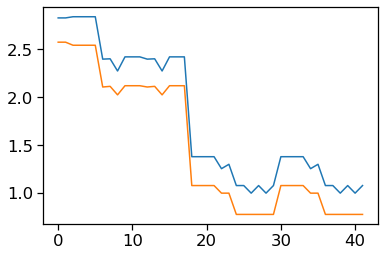

In [23]:
keep['gc.content'] = [(s.count('G')+s.count('C'))/float(len(s)) for s in keep.seq]
keep['nmotifs'] = [len(c.split(',')) for c in keep['tf']]
keep['nunique'] = [len(set(c.split(','))) for c in keep['tf']]
keep_melt = pd.melt(keep,id_vars = ['gc.content','seq','background','tf','control','nmotifs','nunique'],
                   value_vars = ['rarrxr1_slotv4_mesc_repa Dpn Ratio',
                                 'rarrxr1_slotv4_endoderm_rep1b Dpn Ratio',
                                'rarrxr1_slotv4_endoderm_rep2b Dpn Ratio', 
                                 'rarrxr1_slotv4_mesc_repb Dpn Ratio']).dropna()
keep_melt['celltype'] = [v.split('_')[2] for v in keep_melt.variable]
reps = list(set(keep_melt['variable']))
celltypes = ['mesc','endoderm']
tfs = ['oct4','sox2','klf4','foxa2','gata4','sox17']
test_bgs = ['"1470,scrambled-2,None"',
             '"1470,scrambled-5,None"',
             '"1505,scrambled-5,None"']
specific_tfs = ['gata4,foxa2','foxa2,gata4','gata4,sox17','sox17,gata4','oct4,klf4','klf4,oct4',
               'klf4,oct4,sox2',
                 'klf4,sox2,oct4',
                 'oct4,klf4,sox2',
                 'oct4,sox2,klf4',
                 'sox2,klf4,oct4',
                 'sox2,oct4,klf4']
train_data = keep_melt[~keep_melt['background'].isin(test_bgs)]
test_data = keep_melt[keep_melt['background'].isin(test_bgs)]
train_exog = np.zeros((len(train_data),2+len(reps)+len(celltypes)*len(tfs)+len(specific_tfs)*len(celltypes)))
test_exog = np.zeros((len(test_data),2+len(reps)+len(celltypes)*len(tfs)+len(specific_tfs)*len(celltypes)))
#set Y
test_endog = test_data['value']
train_endog = train_data['value']


#set X
start=0
for i,ct in enumerate(celltypes):
    train_exog[:,start+i] = (train_data['celltype']==ct)*(train_data['gc.content'])
    test_exog[:,start+i] = (test_data['celltype']==ct)*(test_data['gc.content'])
start += 2

for j,rep in enumerate(reps):
    train_exog[:,start+j] = (train_data['variable']==rep)
    test_exog[:,start+j] = (test_data['variable']==rep)
start += len(reps)

for i,ct in enumerate(celltypes):
    for j,tf in enumerate(tfs):
        def count_tfs(cat):
            data=cat.split(',')
            if tf in data:
                return data.count(tf)
            else:
                return 0
        mask = (train_data['celltype']==ct)*(train_data['control']=='motif')
        tf_counts = np.array([count_tfs(cat) for cat in train_data.tf])
        train_exog[:,start+j] = tf_counts*mask    
        mask = (test_data['celltype']==ct)*(test_data['control']=='motif')
        tf_counts = np.array([count_tfs(cat) for cat in test_data.tf])
        test_exog[:,start+j] = tf_counts*mask    
    start += len(tfs)
for i,ct in enumerate(celltypes):
    for j,tf in enumerate(specific_tfs):
        def count_tfs(cat):
            #data=cat.split(',')
            return(int(cat==tf))
            #else:
            #    return 0
        mask = (train_data['celltype']==ct)*(train_data['control']=='motif')
        tf_counts = np.array([count_tfs(cat) for cat in train_data.tf])
        train_exog[:,start+j] = tf_counts*mask    
        mask = (test_data['celltype']==ct)*(test_data['control']=='motif')
        tf_counts = np.array([count_tfs(cat) for cat in test_data.tf])
        test_exog[:,start+j] = tf_counts*mask    
    start += len(specific_tfs)
plt.plot(np.log10(np.sum(train_exog,axis=0)))
plt.plot(np.log10(np.sum(test_exog,axis=0)))

In [24]:
train_exog.shape

(2768, 42)

In [25]:
test_exog.shape

(1396, 42)

/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/seaborn/axisgrid.py:1741: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


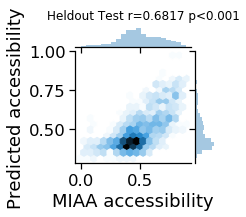

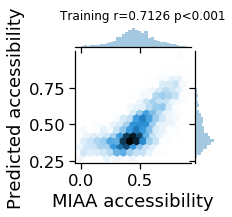

In [25]:
result = OLS(train_endog,train_exog).fit()
pred = result.predict(test_exog)
pcor = pearsonr(test_endog,pred)
plot_scatter(test_endog,pred,xlabel='MIAA accessibility',ylabel='Predicted accessibility',
             kind='hex',
             title='Heldout Test')
pred = result.predict(train_exog)
pcor = pearsonr(train_endog,pred)
plt.savefig('plots/OSK_FGS_GC-nmotif-tf-model_test.svg')
plot_scatter(train_endog,pred,xlabel='MIAA accessibility',ylabel='Predicted accessibility',
             kind='hex',
             title='Training')
plt.savefig('plots/OSK_FGS_GC-nmotif-tf-model_train.svg')

In [29]:
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin

class SMFormulaWrapper(BaseEstimator, RegressorMixin):
    """ A sklearn-style wrapper for formula-based statsmodels regressors """
    def __init__(self, results):
        self.results_ = results
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return self.results_.predict(X)
    
test_exog_tf = test_exog[test_data['control']=='motif']
test_endog_tf = test_endog[test_data['control']=='motif']

lrmodel = SMFormulaWrapper(result)
permute_scored = permutation_importance(lrmodel,test_exog_tf,test_endog_tf)

In [30]:
permute_scored['importances_mean'].shape

(42,)

In [31]:
param_names = ['ESC-GC','DE-GC']+reps+['ESC-'+tf for tf in tfs]+['DE-'+tf for tf in tfs]+['ESC-'+tf for tf in specific_tfs]+['DE-'+tf for tf in specific_tfs]

param_dict = {'param':[],'importance':[],'effect':[]}

def interpret(specific):
    if 'GC' in specific:
        return 'GC-content'
    elif ',' in specific:
        return 'transcription factor combination'
    elif 'nmotifs' in specific:
        return 'number of motifs'
    elif 'rep' in specific:
        return 'replicate'
    else:
        return 'transcription factor presence'
    
for expt in range(permute_scored['importances'].shape[1]):
    param_dict['param'].extend(param_names)
    param_dict['importance'].extend(permute_scored['importances'][:,expt])
    param_dict['effect'].extend([interpret(param) for param in param_names])

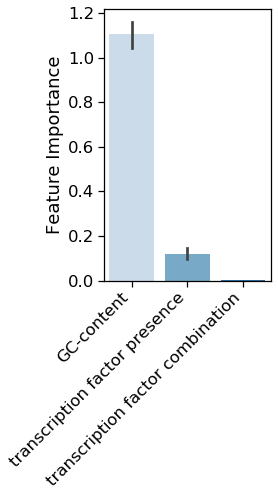

In [37]:
plt.figure(figsize=(3,5))
order = [param_names[i] for i in np.argsort(permute_scored['importances_mean'])]
sns.barplot(x='effect',y='importance',
            data=pd.DataFrame(param_dict),
            order=['GC-content','transcription factor presence',
                   'transcription factor combination'],palette='Blues')
plt.xticks(rotation=45,ha='right')
plt.ylabel('Feature Importance')
plt.xlabel('')
plt.savefig('plots/OSK_FGS_model_effects.svg')

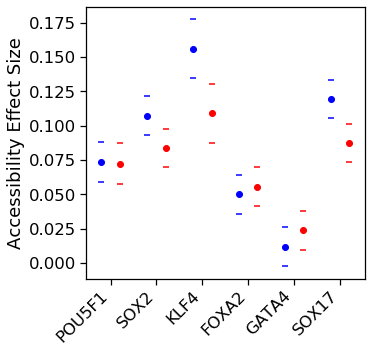

In [65]:
plt.figure(figsize=(5,5))
tfs_MIAA_acc = result.params[2+len(reps):(2+len(reps)+len(tfs)*2)]
ES_acc = tfs_MIAA_acc[:len(tfs)]
DE_acc = tfs_MIAA_acc[len(tfs):]
MIAA_CI = result.conf_int()
tfs_MIAA_CI = MIAA_CI[2+len(reps):(2+len(reps)+len(tfs)*2)]
ES_ci = tfs_MIAA_CI[:len(tfs)]
DE_ci = tfs_MIAA_CI[len(tfs):]
plt.scatter(np.arange(len(tfs))-0.2,ES_acc,color='blue')
plt.scatter(np.arange(len(tfs))-0.2,ES_ci[0],color='blue',marker='_')
plt.scatter(np.arange(len(tfs))-0.2,ES_ci[1],color='blue',marker='_')

plt.scatter(np.arange(len(tfs))+0.2,DE_acc,color='red')
plt.scatter(np.arange(len(tfs))+0.2,DE_ci[0],color='red',marker='_')
plt.scatter(np.arange(len(tfs))+0.2,DE_ci[1],color='red',marker='_')
plt.xticks(np.arange(len(tfs)),[tf2name[tf] for tf in tfs],rotation=45,ha='right')
plt.ylabel('Accessibility Effect Size')
plt.savefig('plots/OSKFGS_accessibility_effect_size.svg')